# Performing a Sentiment Analysis of Energy Crude Oil Tweets

In [1]:
#installing contractions library
!pip -q install contractions

## Importing Libraries & Loading Dataset

In [4]:
#Generic Data Processing & Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,string,unicodedata
import contractions #import contractions_dict
from bs4 import BeautifulSoup
%matplotlib inline


#Importing text processing libraries
import spacy
import spacy.cli
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#downloading wordnet/punkt dictionary
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package wordnet to /Users/jeudi/nltk_data...
[nltk_data] Downloading package punkt to /Users/jeudi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/jeudi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [65]:
#Loading Dataset
oil = pd.read_csv('oil_sentences.csv')
climate = pd.read_csv('climate_sentences.csv')
data = pd.read_csv('presidential_speeches.csv')

## Data Exploration

In [66]:
#Resetting Index
oil.reset_index(drop=True, inplace=True)
climate.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [67]:
#Backup of the newly created dataset
oil_backup = oil.copy()
climate_backup = climate.copy()
data_backup = data.copy()

In [74]:
oil.rename(columns={'oil_sentences':'text'}, inplace=True)
climate.rename(columns={'climate_sentences':'text'}, inplace=True)

## Text Cleaning

In [75]:
#lowering cases
oil['text'] = oil['text'].str.lower()
climate['text'] = climate['text'].str.lower()

In [76]:
#stripping leading spaces (if any)
oil['text'] = oil['text'].str.strip()
climate['text'] = climate['text'].str.strip()

In [78]:
# Removing HTML tags
def strip_html_tags(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text()
        return stripped_text
    except Exception as e:
        return text

#apply to the dataset
oil['text'] = oil['text'].apply(strip_html_tags)
climate['text'] = climate['text'].apply(strip_html_tags)



In [79]:
# Remove URL and links
def strip_url(text):
    try:
        strip_url_text = re.sub(r'http\S+', '', text)
        return strip_url_text
    except:
        return text

#Applying the dataset
oil['text'] = oil['text'].apply(strip_url)
climate['text'] = climate['text'].apply(strip_url)

In [83]:
oil.dropna(inplace=True)
climate.dropna(inplace=True)

In [84]:
#removing punctuations
from string import punctuation

def remove_punct(text):
  for punctuations in punctuation:
    text = text.replace(punctuations, '')
  return text

#apply to the dataset
oil['text'] = oil['text'].apply(remove_punct)
climate['text'] = climate['text'].apply(remove_punct)

In [85]:
#function to remove special characters
def remove_special_chars(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(remove_special_chars)
climate['text'] = climate['text'].apply(remove_special_chars)

In [86]:
#function to remove macrons & accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(remove_accented_chars)
climate['text'] = climate['text'].apply(remove_accented_chars)

In [87]:
#Function to expand contractions
def expand_contractions(con_text):
  con_text = contractions.fix(con_text)
  return con_text

#applying the function on the clean dataset
oil['text'] = oil['text'].apply(expand_contractions)
climate['text'] = climate['text'].apply(expand_contractions)

In [89]:
#creating a new column in the dataset for word count
oil['word_count'] = oil['text'].apply(lambda x:len(str(x).split(" ")))
climate['word_count'] = climate['text'].apply(lambda x:len(str(x).split(" ")))

In [90]:
#Taking Backup
oil_clean = oil.copy()
climate_clean = climate.copy()

## Text Preprocessing & Normalisation

### Removing Stop Words

In [91]:
#function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#applying the function
oil['text'] = oil['text'].apply(remove_stopwords)
climate['text'] = climate['text'].apply(remove_stopwords)


### Stemming

In [92]:
#Function for stemming
def simple_stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

#applying the function
oil['Stemd_text'] = oil['text'].apply(simple_stemmer)
climate['Stemd_text'] = climate['text'].apply(simple_stemmer)

In [24]:
#rearranging columns
data = data[['screenName','text','Stemd_text','retweetCount','word_count']]

In [94]:
#Taking Backup
oil_prepocessed = oil.copy()
climate_prepocessed = climate.copy()

## Sentiment Analysis - TextBlob Library

In [95]:
#Import Textblob Library
from textblob import TextBlob

In [96]:
#function to perform Textblob Sentiment Analyis
def sentiment_analysis(text):
    polarity = round(TextBlob(text).sentiment.polarity, 3)
    sentiment_categories = ['positive','negative','neutral']
    if polarity > 0:
        return sentiment_categories[0]
    elif polarity < 0:
        return sentiment_categories[1]
    else:
        return sentiment_categories[2]  
        
#Apply to the Stemd_Text
oil['Sentiments'] = [sentiment_analysis(txt) for txt in oil['Stemd_text']]
climate['Sentiments'] = [sentiment_analysis(txt) for txt in climate['Stemd_text']]

## Analysis & Visualisation

### Distribution of Word Count

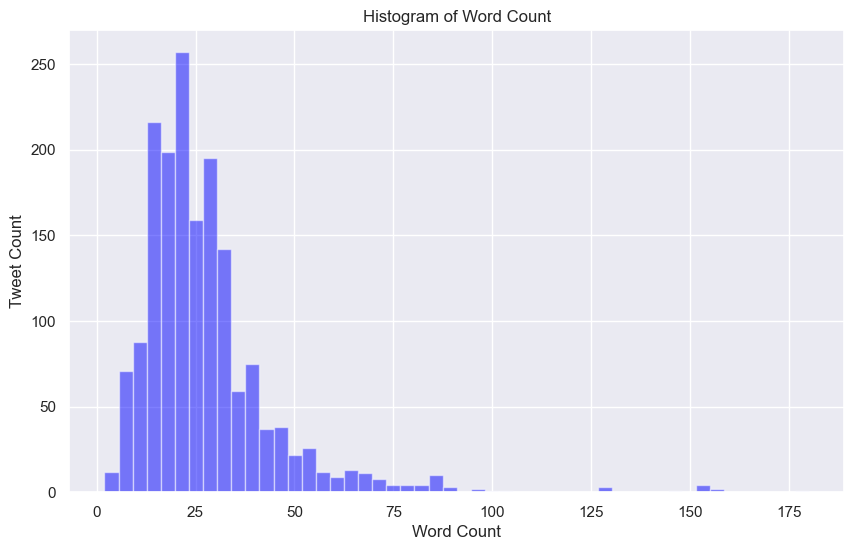

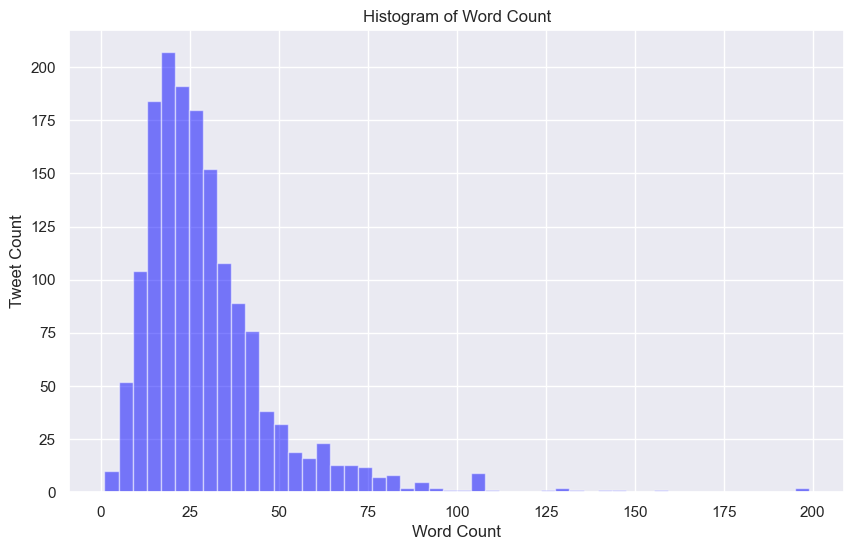

In [97]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(oil.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')
plt.title('Histogram of Word Count')
plt.show();

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(climate.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')
plt.title('Histogram of Word Count')
plt.show();

**Analysis:** skewed to the right, centered at 25.

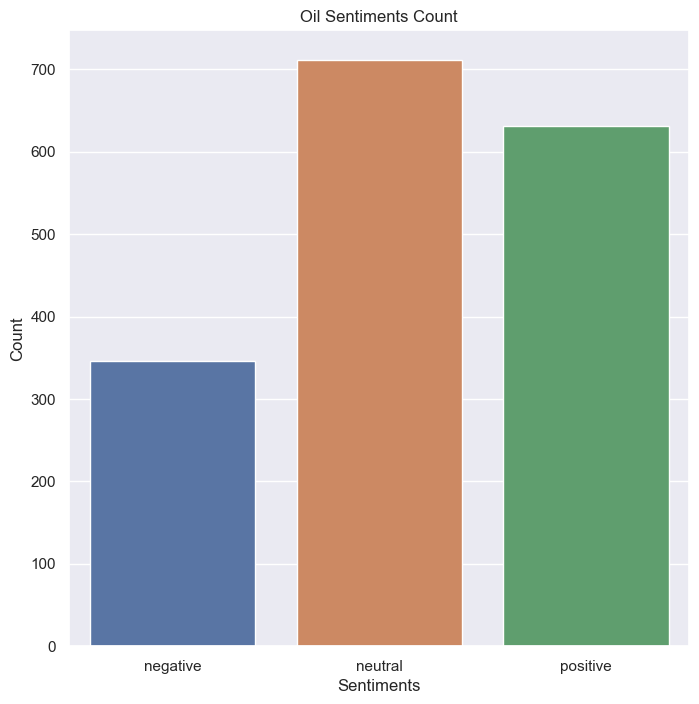

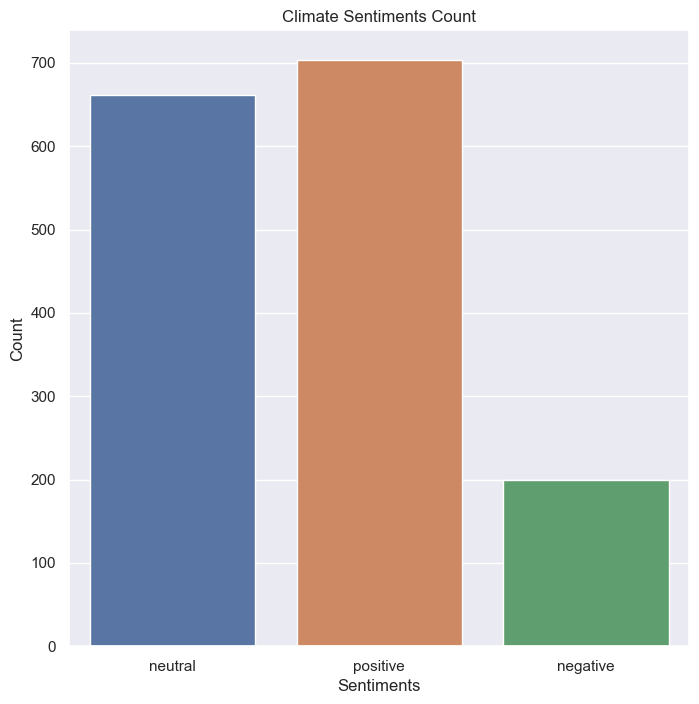

In [98]:
#Creating a Count Plot
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x="Sentiments", data=oil)
plt.title('Oil Sentiments Count')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.show();

#Creating a Count Plot
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x="Sentiments", data=climate)
plt.title('Climate Sentiments Count')
plt.ylabel('Count')
plt.xlabel('Sentiments')
plt.show()

**Analysis:** Majority of the tweets are netural with 'negative' tweets being the second highest

In [32]:
data.head()

,screenName,text,Stemd_text,retweetCount,word_count,Sentiments
0,ArgusMedia,domestic output exceeding regional demand us c...,domest output exceed region demand us crudeoil...,0,17,neutral
1,macrohedged,friday us crude oil front 12 months futures pr...,friday us crude oil front 12 month futur price...,0,24,negative
2,El_Spy,rt aeberman12 opec pumped 296 mmbpd last month...,rt aeberman12 opec pump 296 mmbpd last month 1...,1,22,neutral
3,SuperiorMar,rt aeberman12 ships vanishing tracking screens...,rt aeberman12 ship vanish track screen clandes...,1,18,negative
4,aeberman12,opec pumped 296 mmbpd last month 170 kbd mays ...,opec pump 296 mmbpd last month 170 kbd may rev...,1,20,neutral


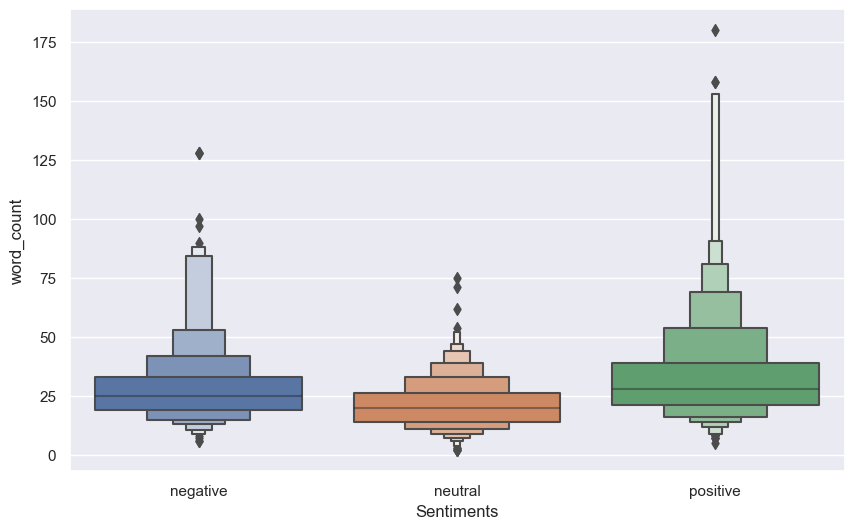

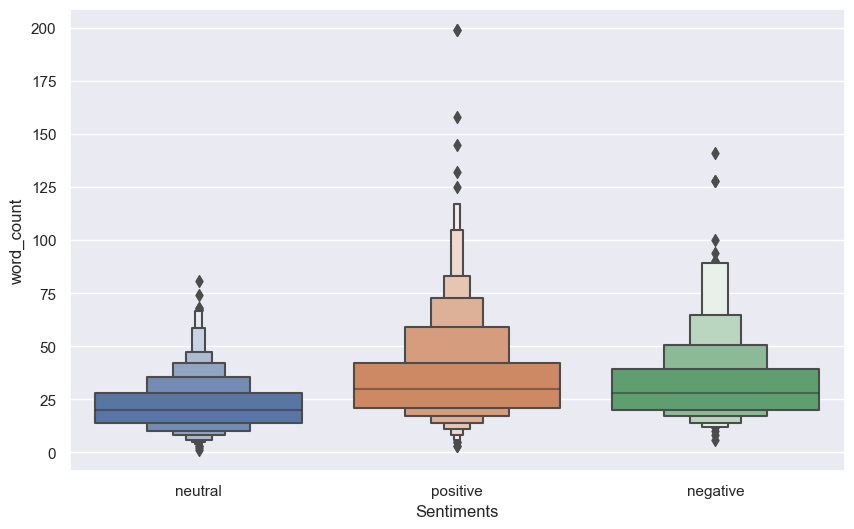

In [99]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='Sentiments', y='word_count', data=oil)
plt.show();

plt.figure(figsize=(10,6))
sns.boxenplot(x='Sentiments', y='word_count', data=climate)
plt.show();

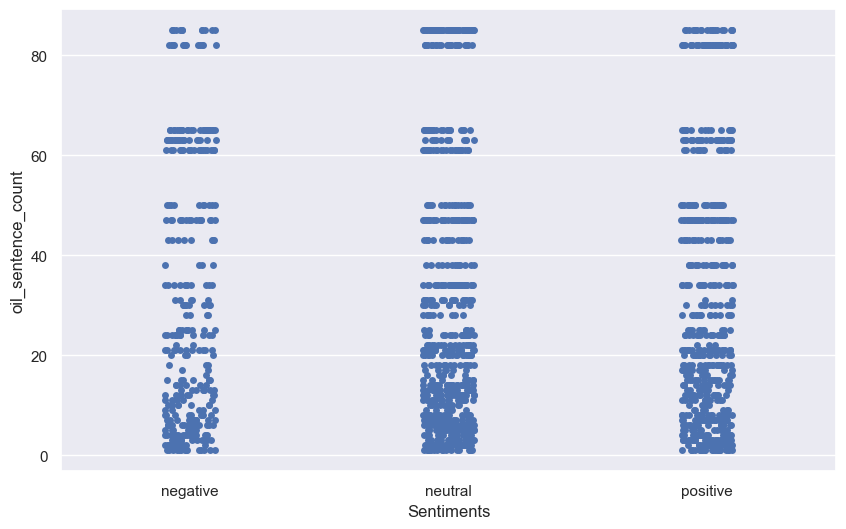

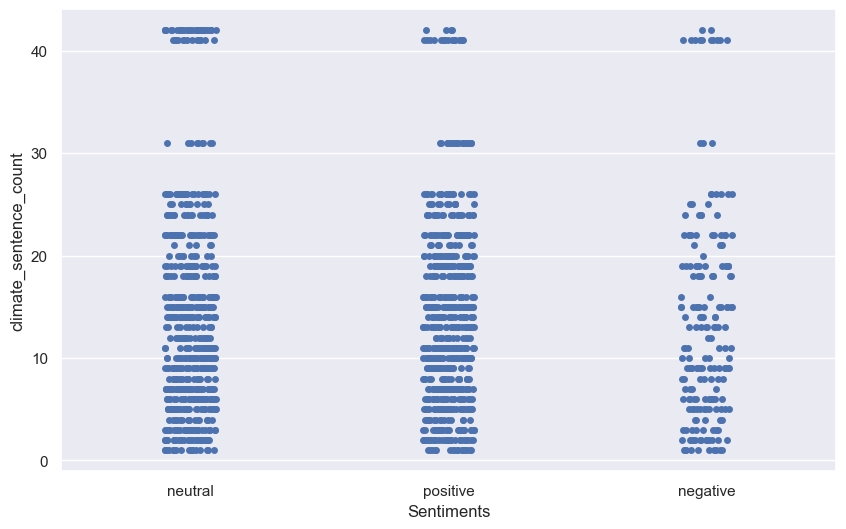

In [101]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Sentiments', y='oil_sentence_count', data=oil)
plt.show();

plt.figure(figsize=(10,6))
sns.stripplot(x='Sentiments', y='climate_sentence_count', data=climate)
plt.show();

### Who are the users who had negative sentiments & a high retweet count ?

In [ ]:
oil[(oil['Sentiments']=='positive') & (oil['word_count'] > 20)].head(10)

In [110]:
# save the cleaned data
oil.to_csv('oil_sentiment.csv', index=False)
climate.to_csv('climate_sentiment.csv', index=False)

In [115]:
# plot sentiment over time

oil['date'] = pd.to_datetime(oil['date'])
climate['date'] = pd.to_datetime(climate['date'])

# map the sentiment to a numerical value
sentiment_map = {'positive': 1, 'negative': -1, 'neutral': 0}
oil['sentiment'] = oil['Sentiments'].map(sentiment_map)
climate['sentiment'] = climate['Sentiments'].map(sentiment_map)

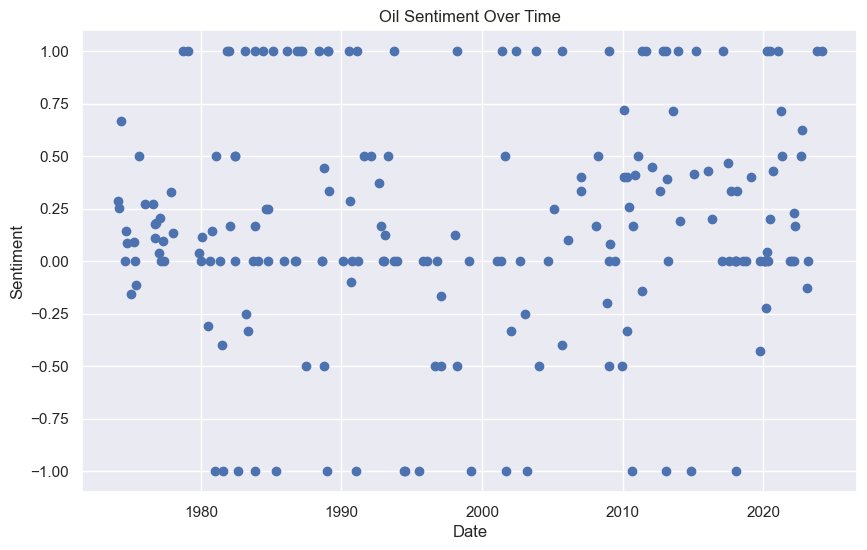

In [118]:
# group by date and calculate the average sentiment
oil_sentiment = oil.groupby('date')['sentiment'].mean().reset_index()

# plot the sentiment over time
plt.figure(figsize=(10,6))
plt.scatter(oil_sentiment['date'], oil_sentiment['sentiment'])
plt.title('Oil Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

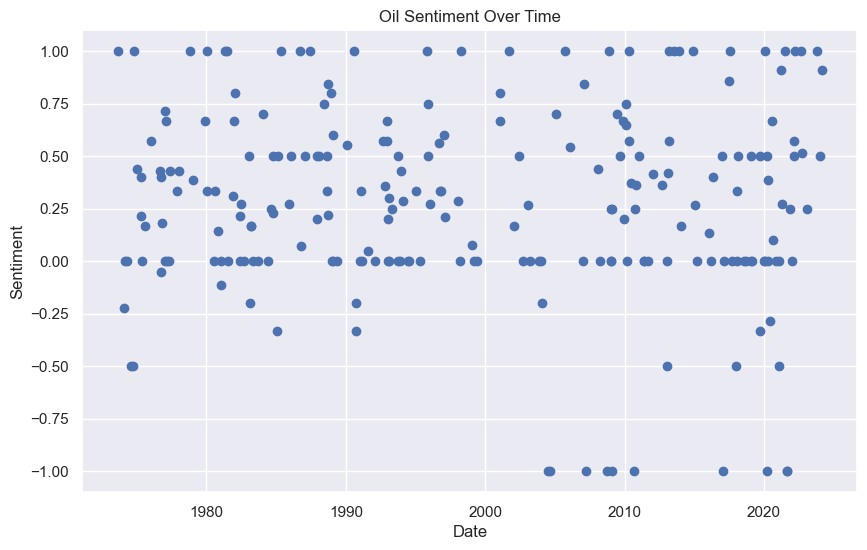

In [119]:
# group by date and calculate the average sentiment
climate_sentiment = climate.groupby('date')['sentiment'].mean().reset_index()

# plot the sentiment over time
plt.figure(figsize=(10,6))
plt.scatter(climate_sentiment['date'], climate_sentiment['sentiment'])
plt.title('Oil Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()